In [1]:
# https://arxiv.org/abs/2312.05491
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM
from captum.attr import LLMGradientAttribution, TextTokenInput, LayerIntegratedGradients

In [2]:
from matplotlib import font_manager, rc
font_path = "/Users/id4thomas/fonts/nanum-gothic/NanumGothic.ttf"
font_manager.fontManager.addfont(font_path)
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [3]:
## Load Model & Tokenizer
model_name = "EleutherAI/polyglot-ko-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(30080, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [4]:
device = "cpu"
model.to(device)
print("Loaded model on", model.device)

Loaded model on cpu


In [5]:
ig = LayerIntegratedGradients(model, model.gpt_neox.embed_in)
llm_attr = LLMGradientAttribution(ig, tokenizer)

In [6]:
"""
attribute 계산에 target을 스트링으로 주는 경우
else:
            assert gen_args is None, "gen_args must be None when target is given"

            if type(target) is str:
                # exclude sos
                target_tokens = self.tokenizer.encode(target)[1:]
                target_tokens = torch.tensor(target_tokens)
            elif type(target) is torch.Tensor:
                target_tokens = target
[1: ] 처리를 해버려서 깨지는 것 같다
"""
def calculate_attributions(
		attribution_fn, tokenizer, 
		template, 
		values, 
		target = None
	):
	print(template.format(*values))
	input_text = template.format(*values)
	inp = TextTokenInput(
		input_text, tokenizer
	)
	input_ids = tokenizer(input_text, return_tensors="pt")["input_ids"][0]
	if target:
		target_ids = tokenizer(target, return_tensors="pt")["input_ids"][0]
		res = attribution_fn.attribute(inp, target = target_ids)
		res.output_tokens = [tokenizer.decode(id) for id in target_ids]
	else:
		res = attribution_fn.attribute(inp)

	res.input_tokens = [tokenizer.decode(id) for id in input_ids]
	return res

In [7]:
res1 = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["바다"],
	target = "수영을 했다"
)

나는 바다에서


In [9]:
res2 = calculate_attributions(
	llm_attr, tokenizer,
	"나는 {}에서",
	values = ["산"],
	target = "수영을 했다"
)

나는 산에서


In [10]:
print(res1.input_tokens)
print(res1.output_tokens)

['나', '는', ' 바다', '에서']
['수영', '을', ' 했', '다']


/Users/id4thomas/miniforge3/envs/llm/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


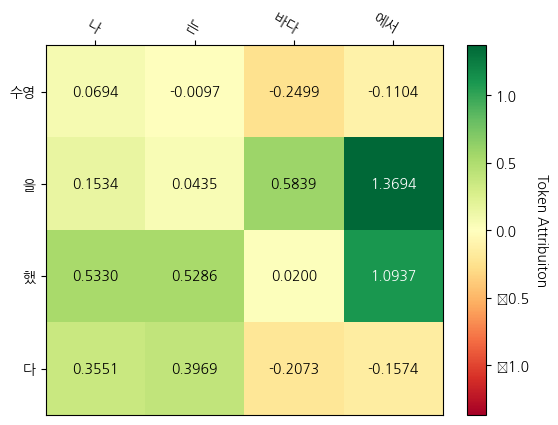

In [11]:
res1.plot_token_attr(show = True)

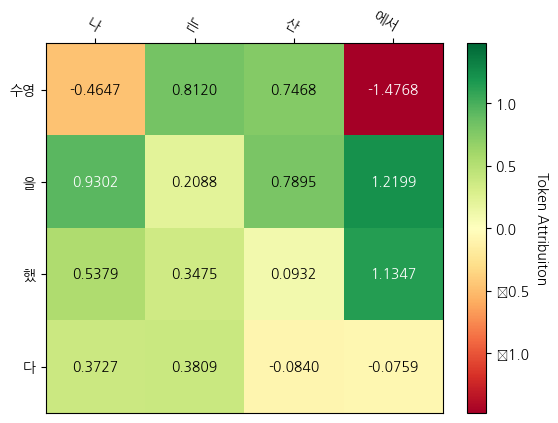

In [12]:
res2.plot_token_attr(show = True)